In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Colab Notebooks/Machine learning/Practicum II: Image classification and Object Localization using deep learning

/content/drive/MyDrive/Colab Notebooks/Machine learning/Practicum II: Image classification and Object Localization using deep learning


In [4]:
!rm -rf week16_lab
!rm -rf week16_lab*zip

# download image package
!wget https://cs.slu.edu/~hou/5750/week16_lab.zip --no-check-certificate

# unzip file
!unzip week16_lab.zip

--2022-12-17 04:03:42--  https://cs.slu.edu/~hou/5750/week16_lab.zip
Resolving cs.slu.edu (cs.slu.edu)... 165.134.107.79
Connecting to cs.slu.edu (cs.slu.edu)|165.134.107.79|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 15436402 (15M) [application/zip]
Saving to: ‘week16_lab.zip’

week16_lab.zip      100%[===================>]  14.72M  1.62MB/s    in 9.1s    

2022-12-17 04:03:55 (1.62 MB/s) - ‘week16_lab.zip’ saved [15436402/15436402]

Archive:  week16_lab.zip
   creating: week16_lab/
  inflating: week16_lab/week16-Lab-data-object-5000imgs.npy  
  inflating: week16_lab/week16-Lab-data-boundingbox-5000imgs.npy  
  inflating: week16_lab/Flowchart.png  
 extracting: week16_lab/dataset_object.zip  
  inflating: week16_lab/label_image_1.png  
  inflating: week16_lab/label_image.png  
  inflating: week16_lab/labelImg_1.png  
   creating: week16_lab/dataset_object/
   creating: week16_lab/dataset_object/test_data/

In [6]:
!ls ./week16_lab

dataset_object	    labelImg_1.png  LabelImg_6.png
dataset_object.zip  LabelImg_2.png  text.png
Flowchart.png	    LabelImg_3.png  week16-Lab-data-boundingbox-5000imgs.npy
label_image_1.png   LabelImg_4.png  week16-Lab-data-object-5000imgs.npy
label_image.png     LabelImg_5.png  xml_voc.png


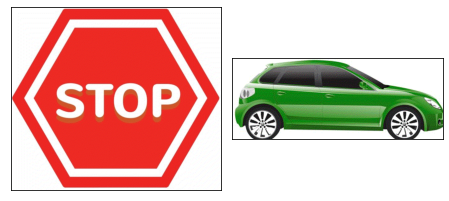

In [7]:
#Step 2.1: load necessary libraries
from matplotlib import pyplot as plt
import glob
import base64
from PIL import Image
import numpy as np

#Step 2.2: visualize image
fig = plt.figure(figsize=(6, 6)) # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

## plot first image
img_path ='week16_lab/dataset_object/StopSign_1.jpg'
ax = fig.add_subplot(1,2,1, xticks=[], yticks=[])

# PIL image, convert to mode "P" to translates pixels through the palette and range of pixels still in [0,255] with color image 
img = Image.open(img_path).convert("P") 
ax.imshow(img)
img.close()

## plot second image
img_path ='week16_lab/dataset_object/car_1.jpg'
ax = fig.add_subplot(1,2,2, xticks=[], yticks=[])
img = Image.open(img_path).convert("P") 
ax.imshow(img)
img.close()

In [8]:
# Step 3.1: Load the pre-generated image and bounding box information
import numpy as np
imgs = np.load("week16_lab/week16-Lab-data-object-5000imgs.npy")
bboxes = np.load("week16_lab/week16-Lab-data-boundingbox-5000imgs.npy")

# Step 3.2: examine the shape of the data
print("check inputs and outputs:",imgs.shape, bboxes.shape)

check inputs and outputs: (5000, 128, 128) (5000, 1, 4)


In [10]:
bboxes

array([[[84., 16., 34., 35.]],

       [[52., 81., 36., 33.]],

       [[17., 44., 45., 38.]],

       ...,

       [[ 7., 37., 31., 48.]],

       [[81., 15., 37., 35.]],

       [[73., 51., 48., 37.]]])

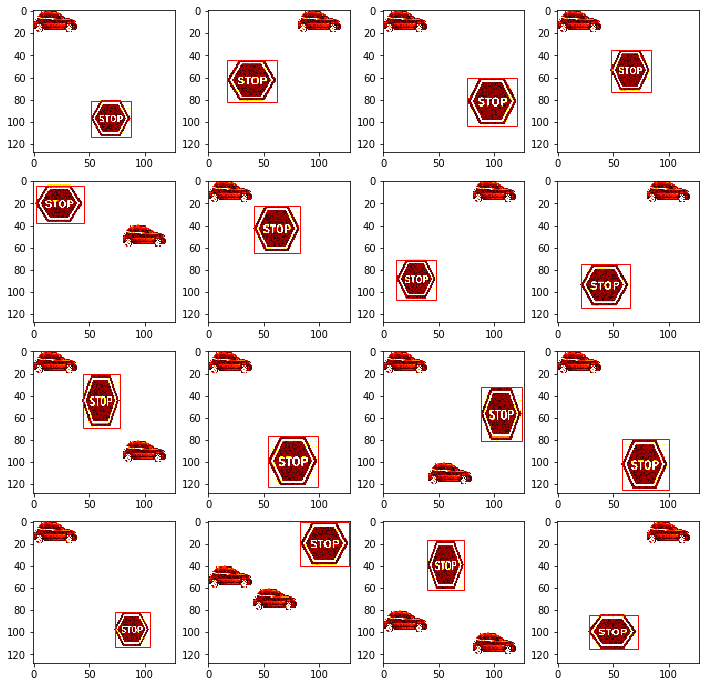

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import PIL
%matplotlib inline

plt.figure(figsize=(12, 12))
for img_idx in range(1,17):
    plt.subplot(4, 4, img_idx)
    img = PIL.Image.fromarray(imgs[img_idx])
    plt.imshow(imgs[img_idx], cmap='hot', interpolation='nearest')

    for bbox in bboxes[img_idx]:
       plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], ec='r', fc='none'))

In [ ]:
bboxes

array([[[84., 16., 34., 35.]],

       [[52., 81., 36., 33.]],

       [[17., 44., 45., 38.]],

       ...,

       [[ 7., 37., 31., 48.]],

       [[81., 15., 37., 35.]],

       [[73., 51., 48., 37.]]])

In [ ]:
N_train = imgs.shape[0]  # the first dimension of the tensor is number of total images
D_train = 128*128*1   # the remaining dimensions of the tensor is the shape of image, you can also use X_data.shape[1]*X_data.shape[2]*X_data.shape[3]
image_X = imgs.reshape(N_train, D_train)
image_X = image_X.astype('float32')
image_X /= 255 # scale the pixels using min-max normalization


In [ ]:

# Step 7.1: scale the location coordinate based on image size
num_imgs = bboxes.shape[0]
img_size = 128
bboxes_y = bboxes.reshape(num_imgs, 4) / img_size

# Step 7.2: check the statistics of new bounding box locations
print(bboxes_y.shape, np.mean(bboxes_y), np.std(bboxes_y))

(5000, 4) 0.32422109375 0.146724802671928


In [ ]:
# Step 8.1: Generate training/validation/testing
from sklearn.model_selection import ShuffleSplit
split = ShuffleSplit(n_splits=1, test_size=.2, random_state=0)

for train_index, test_index in split.split(image_X):
    #print("TRAIN:", train_index, "\nTEST:", test_index)
    # Step 8.2: Get training data  that has scaled bounding box
    train_X = image_X[train_index]
    train_y = bboxes_y[train_index]
    # Step 8.3: Get test data that has scaled bounding box
    test_X = image_X[test_index]
    test_y = bboxes_y[test_index]
    # Step 8.4: Get test data that has unscaled bounding box
    test_imgs = imgs[test_index]
    test_bboxes = bboxes[test_index]

In [ ]:
# Step 9.1: Define the function
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
keras_callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, mode='min', min_delta=0.0001),
    ModelCheckpoint('./checkmodel.h5', monitor='val_loss', save_best_only=True, mode='min')
]

from keras.layers import Dropout,Activation
from keras.layers import BatchNormalization
from keras.regularizers import l2
from keras import initializers


def build_model(n_layers = 2, n_neurons = 1000, initializer='uniform'):
    if initializer == 'uniform':
         w_in = np.sqrt(0.001)
         initializer = initializers.RandomUniform(minval=-w_in, maxval=w_in)
    else:
         #https://www.tensorflow.org/api_docs/python/tf/keras/initializers/GlorotNormal
         initializer = initializers.glorot_normal()

    model = Sequential() # create Sequential model

    for i in range(n_layers-1):
        if i == 0:
            model.add(Dense(n_neurons, input_shape=(128*128,), kernel_initializer=initializer))
        else:
            model.add(Dense(n_neurons, kernel_initializer=initializer))
        model.add(BatchNormalization()) ## add batch normalization before activation
        model.add(Activation('relu'))

        model.add(Dropout(0.2))
    model.add(Dense(4, activation = 'sigmoid', kernel_initializer=initializer)) 

    return model

# Step 9.2: define the deep learning model
model = build_model(n_layers = 3, n_neurons = 100, initializer='glorot_normal')
model.compile(loss = "mean_squared_error", optimizer = "adam", metrics = ['mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               1638500   
                                                                 
 batch_normalization (BatchN  (None, 100)              400       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 100)               0         
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 batch_normalization_1 (Batc  (None, 100)              400       
 hNormalization)                                        

In [ ]:
from keras.layers.pooling import MaxPooling2D
# Step 9.1: Define the function
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
keras_callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, mode='min', min_delta=0.0001),
    ModelCheckpoint('./checkmodel.h5', monitor='val_loss', save_best_only=True, mode='min')
]

from keras.layers import Dropout,Activation
from keras.layers import BatchNormalization, Conv2D, Flatten
from keras.regularizers import l2
from keras import initializers


def build_model_CNN(n_layers = 2, n_neurons = 1000, initializer='uniform'):
    if initializer == 'uniform':
         w_in = np.sqrt(0.001)
         initializer = initializers.RandomUniform(minval=-w_in, maxval=w_in)
    else:
         #https://www.tensorflow.org/api_docs/python/tf/keras/initializers/GlorotNormal
         initializer = initializers.glorot_normal()

    model = Sequential() # create Sequential model

    for i in range(n_layers-1):
        if i == 0:
            model.add(Conv2D(filters=10, kernel_size=(3,3), padding='same', input_shape=(128,128,1)))
        else:
            model.add(Conv2D(filters=10, kernel_size=(3,3), padding='same'))
        model.add(BatchNormalization()) ## add batch normalization before activation
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size = (2,2)))

        model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(4, activation = 'sigmoid', kernel_initializer=initializer)) 

    return model

# Step 9.2: define the deep learning model
model_CNN = build_model_CNN(n_layers = 3, n_neurons = 100, initializer='glorot_normal')
model_CNN.compile(loss = "mean_squared_error", optimizer = "adam", metrics = ['mse'])
model_CNN.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 128, 128, 10)      100       
                                                                 
 batch_normalization_10 (Bat  (None, 128, 128, 10)     40        
 chNormalization)                                                
                                                                 
 activation_10 (Activation)  (None, 128, 128, 10)      0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 64, 64, 10)       0         
 2D)                                                             
                                                                 
 dropout_10 (Dropout)        (None, 64, 64, 10)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 64, 10)       

In [ ]:
train_X.shape

(4000, 16384)

In [ ]:
train_X_CNN = train_X.reshape((4000, 128,128,1))

In [ ]:
# Step 10: training the neural network using feature and labels
train_history_CNN = model_CNN.fit(train_X_CNN,train_y, validation_split=0.1, batch_size = 25, epochs = 1, callbacks=keras_callbacks)

144/144 [==============================] - 31s 213ms/step - loss: 0.0494 - mse: 0.0494 - val_loss: 0.0509 - val_mse: 0.0509


In [ ]:
# Step 10: training the neural network using feature and labels
train_history = model.fit(train_X,train_y, validation_split=0.1, batch_size = 25, epochs = 1, callbacks=keras_callbacks)

144/144 [==============================] - 2s 15ms/step - loss: 0.0065 - mse: 0.0065 - val_loss: 0.0061 - val_mse: 0.0061


In [ ]:
# Step 12.1: save the trained model into disk
from keras.models import load_model
# save the model to disk
model.save("object_detection_model_simple.h5")

# Step 12.2:load the model from disk
model_loaded = load_model("object_detection_model_simple.h5")

In [ ]:
# Step 13.1: predict the location of bounding box of test set
pred_y = model.predict(test_X)
pred_y

array([[0.6393551 , 0.3670147 , 0.20187578, 0.20731443],
       [0.293618  , 0.5695993 , 0.2799164 , 0.22946692],
       [0.32914904, 0.49883193, 0.25866348, 0.22782725],
       ...,
       [0.30480704, 0.43864968, 0.24300545, 0.22037658],
       [0.52994967, 0.06438792, 0.20621562, 0.25616103],
       [0.2704689 , 0.26002216, 0.29018253, 0.22780898]], dtype=float32)

In [ ]:
test_X.shape

(1000, 16384)

In [ ]:
# Step 13.2: resize the location of bounding box to fit the size of original image
pred_bboxes = pred_y * img_size
pred_bboxes = pred_bboxes.reshape(len(pred_bboxes), 1, -1)
print("shape: ", pred_bboxes.shape)
print("pred_bboxes: ",pred_bboxes)

shape:  (1000, 1, 4)
pred_bboxes:  [[[81.837456 46.977882 25.8401   26.536247]]

 [[37.583103 72.90871  35.8293   29.371765]]

 [[42.131077 63.850487 33.108925 29.161888]]

 ...

 [[39.0153   56.14716  31.104698 28.208202]]

 [[67.83356   8.241653 26.3956   32.788612]]

 [[34.620018 33.282837 37.143364 29.15955 ]]]


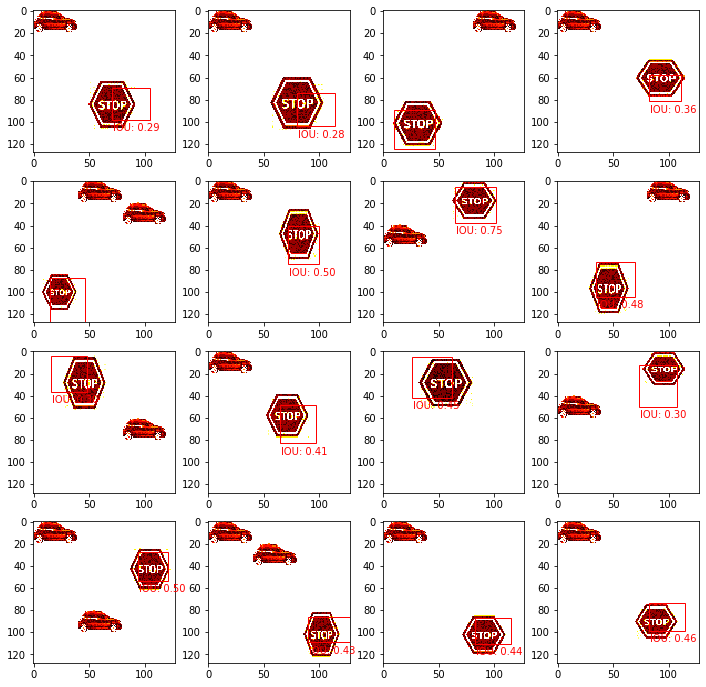

In [ ]:
# Step 15: visualized the predicted bounding box
plt.figure(figsize=(12, 12))
for i_subplot in range(1, 17):
    plt.subplot(4, 4, i_subplot)
    i = np.random.randint(len(test_imgs))
    plt.imshow(test_imgs[i], cmap='hot', interpolation='nearest')
    for pred_bbox, exp_bbox in zip(pred_bboxes[i], test_bboxes[i]):
       plt.gca().add_patch(matplotlib.patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2], pred_bbox[3], ec='r', fc='none'))
       plt.annotate('IOU: {:.2f}'.format(IOU(pred_bbox, exp_bbox)), (pred_bbox[0]+1, pred_bbox[1]+pred_bbox[3]+10), color='r')

In [ ]:
# Step 14.1 Define the calculation of IoU score
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)

    if w_I <= 0 or h_I <= 0: # no overlap
        return 0

    I = w_I * h_I
    U = w1 * h1 + w2 * h2 - I
    return I / U